In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import statsmodels.api as sm

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_csv("mmm-data.csv")

In [5]:
df

,date,revenue,sales,ppc,audio,programmatic,price
0,2022-10-04,153947.474881,6806.728016,20895.535910,6833.720122,7077.616802,22.994641
1,2023-01-03,168779.746845,7580.893404,23756.267739,5795.531489,3959.879104,22.975616
2,2023-08-15,162331.810073,6915.491369,21670.185251,8516.175140,6329.598683,22.579929
3,2021-09-07,140690.210840,6295.734847,15608.221925,6601.864618,4364.847883,22.525832
4,2024-01-23,159894.926700,6872.451808,18461.981130,6119.875868,4811.224815,22.639095
...,...,...,...,...,...,...,...
148,2021-12-28,168627.170515,7419.126417,18673.513294,6238.566155,4933.701150,23.031575
149,2023-12-19,157579.455551,6997.964722,23305.606289,5747.870675,2796.821806,23.174521
150,2023-10-31,161088.973845,7031.032478,16538.376985,6442.439475,873.783918,23.438769
151,2021-07-20,146432.323800,6104.988239,21082.300191,7728.307956,5830.198537,22.821772


# EDA

In [6]:
df.isna().values.any()

True

In [7]:
#locate rows where null values appear
NaN_rows = df[df.isnull().any(axis=1)]  
NaN_rows

,date,revenue,sales,ppc,audio,programmatic,price
42,2022-12-27,153867.373643,6893.143206,24413.383691,NaN,4943.378258,23.198935
62,2022-02-15,194707.222215,8808.886776,18066.664277,7920.170709,NaN,22.469154
68,2021-11-16,NaN,NaN,21798.544965,7139.043482,4986.975773,23.493160
91,2022-11-29,NaN,NaN,18094.552020,5510.867940,3253.301161,23.434938


In [8]:
#locate columns where null values appear
NaN_columns = df.isna().any()
NaN_columns

date            False
revenue          True
sales            True
ppc             False
audio            True
programmatic     True
price           False
dtype: bool

In [9]:
# replace the nan values in 'revenue' and 'sales' with the mean values in the column
df.at[68, 'revenue'] = df['revenue'].mean()
df.at[68, 'sales'] = df['sales'].mean()
df.at[91, 'revenue'] = df['revenue'].mean()
df.at[91, 'sales'] = df['sales'].mean()

In [10]:
df.at[42, 'audio'] = df['audio'].mean()
df.at[62, 'programmatic'] = df['programmatic'].mean()

In [11]:
#locate rows where null values appear
NaN_rows = df[df.isnull().any(axis=1)]  
NaN_rows

,date,revenue,sales,ppc,audio,programmatic,price


In [12]:
#find the rows where there are negative values in the dataframe
df.iloc[:,1:7][df.iloc[:,1:7]< 0].stack().index[0][0]

146

In [13]:
# drop the rows where there are negative values by index
df.drop([df.iloc[:,1:7][df.iloc[:,1:7]< 0].stack().index[0][0]],inplace=True)

In [14]:
# check again if there are any negative values in the dataframe
df.iloc[:,1:7][df.iloc[:,1:7]< 0].stack()

Series([], dtype: float64)

## date

In [15]:
df.dtypes

date             object
revenue         float64
sales           float64
ppc             float64
audio           float64
programmatic    float64
price           float64
dtype: object

In [16]:
# convert the date column into datetime 
df['date'] = pd.to_datetime(df['date'])

In [17]:
df.dtypes

date            datetime64[ns]
revenue                float64
sales                  float64
ppc                    float64
audio                  float64
programmatic           float64
price                  float64
dtype: object

In [18]:
df = df.sort_values('date').reset_index(drop=True)
df

,date,revenue,sales,ppc,audio,programmatic,price
0,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563
1,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089
2,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401
3,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207
4,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130
...,...,...,...,...,...,...,...
147,2024-02-27,151329.303068,6813.095961,22212.008767,6749.427632,3093.900164,22.445753
148,2024-03-05,151239.716758,6766.224515,22023.434869,6154.942073,3414.808257,22.524531
149,2024-03-12,139618.945260,6179.983317,15471.939932,7135.498149,2466.111982,22.566400
150,2024-03-19,159966.837688,6772.468366,18461.239025,8322.642229,2755.027559,22.917346


In [19]:
df['date'].diff().value_counts()

date
7 days     147
14 days      4
Name: count, dtype: int64

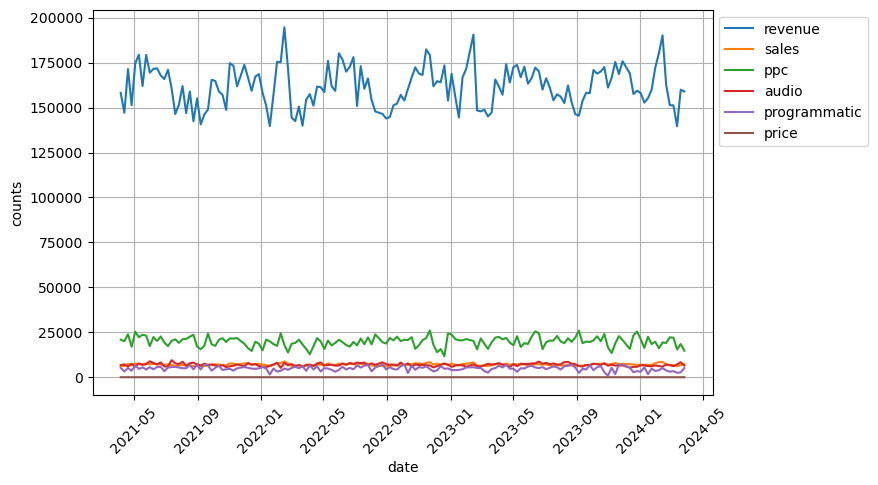

In [20]:
plt.figure(figsize=(8,5))
for i in df.columns[1:11]:
    plt.plot(df['date'],df[i], label=i)
plt.tick_params(axis ='x', rotation=45)
plt.xlabel('date')
plt.ylabel('counts')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

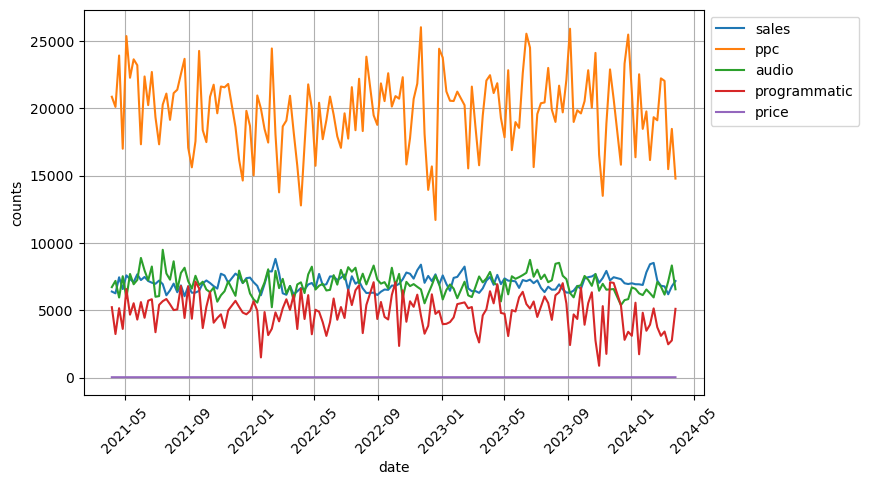

In [21]:
# Look at the plots for sales, ppc spend, audio spend, programmtic spend, price, day, month, year
plt.figure(figsize=(8,5))
for i in df.columns[2:11]:
    plt.plot(df['date'],df[i], label=i)
plt.tick_params(axis ='x', rotation=45)
plt.xlabel('date')
plt.ylabel('counts')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## sales and price

In [22]:
df['sales x price'] = df['sales'] * df['price']
df

,date,revenue,sales,ppc,audio,programmatic,price,sales x price
0,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634
1,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603
2,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873
3,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058
4,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776
...,...,...,...,...,...,...,...,...
147,2024-02-27,151329.303068,6813.095961,22212.008767,6749.427632,3093.900164,22.445753,152925.069792
148,2024-03-05,151239.716758,6766.224515,22023.434869,6154.942073,3414.808257,22.524531,152406.032036
149,2024-03-12,139618.945260,6179.983317,15471.939932,7135.498149,2466.111982,22.566400,139459.973603
150,2024-03-19,159966.837688,6772.468366,18461.239025,8322.642229,2755.027559,22.917346,155207.002392


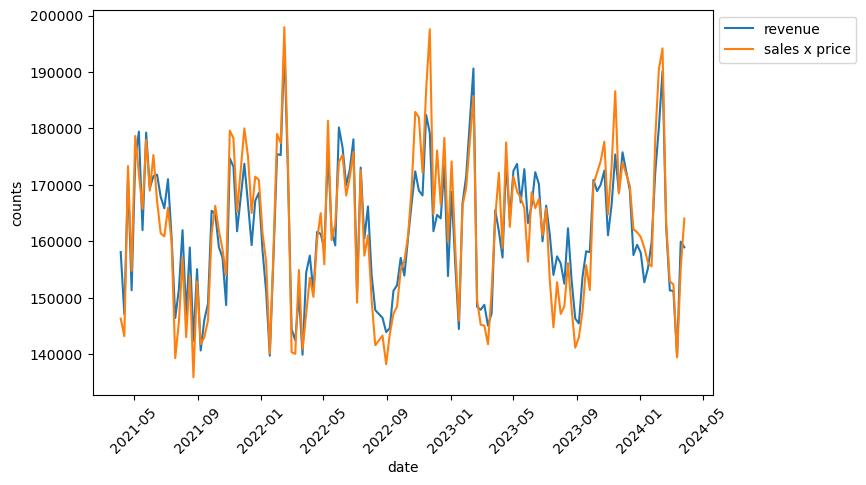

In [23]:
#plot the 'sales x price' and 'revenue' columns against date 
plt.figure(figsize=(8,5))
for i in df.iloc[:,[1,7]]:
    plt.plot(df['date'],df[i], label=i)
plt.tick_params(axis ='x', rotation=45)
plt.xlabel('date')
plt.ylabel('counts')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [24]:
df['log_sales'] = np.log(df['sales']) 
df['log_revenue'] = np.log(df['revenue']) 

- Therefore $'sales' \ \times \ 'price' = \ 'revenue'$  

## Advertising channels

In [25]:
df['log_ppc'] = np.log(df['ppc']) 
df['log_audio'] = np.log(df['audio']) 
df['log_programmatic'] = np.log(df['programmatic']) 
df['ppc_programmatic_audio'] = df['ppc']*df['audio']*df['programmatic']
df['log_ppc_programmatic_audio'] = np.log(df['ppc_programmatic_audio']) 
df

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,log_ppc,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio
0,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,11.971076,9.944974,8.811663,8.560872,7.308752e+11,27.317509
1,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,11.898897,9.908105,8.878494,8.080022,4.656133e+11,26.866621
2,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,12.051863,10.082048,8.689517,8.546151,7.310266e+11,27.317716
3,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,11.927402,9.740259,8.925253,8.191191,4.610180e+11,26.856703
4,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,12.070624,10.140621,8.682583,8.790183,9.825208e+11,27.613387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2024-02-27,151329.303068,6813.095961,22212.008767,6749.427632,3093.900164,22.445753,152925.069792,8.826602,11.927214,10.008388,8.817213,8.037188,4.638324e+11,26.862789
148,2024-03-05,151239.716758,6766.224515,22023.434869,6154.942073,3414.808257,22.524531,152406.032036,8.819699,11.926621,9.999862,8.725011,8.135877,4.628874e+11,26.860750
149,2024-03-12,139618.945260,6179.983317,15471.939932,7135.498149,2466.111982,22.566400,139459.973603,8.729071,11.846672,9.646783,8.872837,7.810398,2.722588e+11,26.330019
150,2024-03-19,159966.837688,6772.468366,18461.239025,8322.642229,2755.027559,22.917346,155207.002392,8.820621,11.982722,9.823429,9.026735,7.921183,4.232998e+11,26.771346


## Pairplots

In [26]:
#g = sns.pairplot(df)
#g.fig.set_size_inches(10,10)

## PPMCC matrix

In [27]:
#contruct a PMCC matrix on the data
corr_matrix = (df).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,log_ppc,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio
date,1.000000,0.033989,0.095249,-0.008051,-0.111293,-0.170155,-0.113822,0.066995,0.097619,0.037279,-0.013366,-0.104069,-0.202456,-0.165252,-0.200397
revenue,0.033989,1.000000,0.933231,0.065151,0.009093,0.054985,0.448185,0.935927,0.935990,0.999073,0.056039,0.004500,0.083591,0.066352,0.090939
sales,0.095249,0.933231,1.000000,0.022813,-0.082389,-0.012059,0.380218,0.985486,0.998707,0.930082,0.007476,-0.087061,0.017310,-0.033028,-0.007918
ppc,-0.008051,0.065151,0.022813,1.000000,-0.020656,0.039597,-0.025327,0.018533,0.023981,0.064514,0.994692,-0.028027,0.035766,0.432713,0.399372
audio,-0.111293,0.009093,-0.082389,-0.020656,1.000000,0.199359,-0.097833,-0.093114,-0.081048,0.011652,-0.010441,0.997236,0.186408,0.488506,0.433814
programmatic,-0.170155,0.054985,-0.012059,0.039597,0.199359,1.000000,-0.028631,-0.015676,-0.008436,0.058100,0.041281,0.197765,0.965252,0.842025,0.861510
price,-0.113822,0.448185,0.380218,-0.025327,-0.097833,-0.028631,1.000000,0.531209,0.398284,0.461182,-0.037625,-0.097551,-0.036607,-0.071323,-0.072150
sales x price,0.066995,0.935927,0.985486,0.018533,-0.093114,-0.015676,0.531209,1.000000,0.987538,0.935358,0.002027,-0.097175,0.009648,-0.041847,-0.019148
log_sales,0.097619,0.935990,0.998707,0.023981,-0.081048,-0.008436,0.398284,0.987538,1.000000,0.934705,0.008581,-0.085982,0.020656,-0.029317,-0.004454
log_revenue,0.037279,0.999073,0.930082,0.064514,0.011652,0.058100,0.461182,0.935358,0.934705,1.000000,0.055173,0.006840,0.086543,0.069478,0.093692


In [28]:
# final dataframe
#df

## Media channel lag effects on sales

In [29]:
def apply_lag(x, length, peak, decay):
    
    x =  np.append(np.zeros(length-1), x)
    
    weights = np.zeros(length)
    for l in range(length):
        weight = decay**((1-peak)**2)
        weights[length-1-l] = weight
    
    adstocked_x = []
    for i in range(length-1, len(x)):
        x_array = x[i-length+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

In [30]:
adstocked_log_ppc = apply_lag(df['log_ppc'], 2, 1, 0.5)
adstocked_log_audio = apply_lag(df['log_audio'], 2, 1, 0.5)
adstocked_log_programmatic = apply_lag(df['log_programmatic'], 2, 1, 0.5)
adstocked_ppc = apply_lag(df['ppc'], 10, 5, 0.9)
adstocked_audio = apply_lag(df['audio'], 10, 5, 0.9)
adstocked_programmatic = apply_lag(df['programmatic'], 10, 5, 0.9)

df['adstocked_log_ppc'] = adstocked_log_ppc
df['adstocked_log_audio'] = adstocked_log_audio
df['adstocked_log_programmatic'] = adstocked_log_programmatic
df['adstocked_ppc'] = adstocked_ppc
df['adstocked_audio'] = adstocked_audio
df['adstocked_programmatic'] = adstocked_programmatic

In [31]:
df

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,...,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic
0,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,11.971076,...,8.811663,8.560872,7.308752e+11,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529
1,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,11.898897,...,8.878494,8.080022,4.656133e+11,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920
2,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,12.051863,...,8.689517,8.546151,7.310266e+11,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513
3,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,11.927402,...,8.925253,8.191191,4.610180e+11,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255
4,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,12.070624,...,8.682583,8.790183,9.825208e+11,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2024-02-27,151329.303068,6813.095961,22212.008767,6749.427632,3093.900164,22.445753,152925.069792,8.826602,11.927214,...,8.817213,8.037188,4.638324e+11,26.862789,9.932891,8.842135,8.130787,20054.017726,6404.386128,3794.451007
148,2024-03-05,151239.716758,6766.224515,22023.434869,6154.942073,3414.808257,22.524531,152406.032036,8.819699,11.926621,...,8.725011,8.135877,4.628874e+11,26.860750,10.004125,8.771112,8.086532,19710.049087,6437.822861,3796.283509
149,2024-03-12,139618.945260,6179.983317,15471.939932,7135.498149,2466.111982,22.566400,139459.973603,8.729071,11.846672,...,8.872837,7.810398,2.722588e+11,26.330019,9.823323,8.798924,7.973137,19137.566478,6482.256382,3733.235731
150,2024-03-19,159966.837688,6772.468366,18461.239025,8322.642229,2755.027559,22.917346,155207.002392,8.820621,11.982722,...,9.026735,7.921183,4.232998e+11,26.771346,9.735106,8.949786,7.865790,19348.185048,6656.379845,3453.238516


In [32]:
from collections import defaultdict

groups = ['ppc','log_ppc','audio','log_audio','programmatic','log_programmatic']

In [33]:
grouped_columns = defaultdict(list)

In [34]:
for col in df.columns:
    if col != 'date': 
        for keyword in groups:
            if keyword in col:
                grouped_columns[keyword].append(col)

print(grouped_columns)

defaultdict(<class 'list'>, {'ppc': ['ppc', 'log_ppc', 'ppc_programmatic_audio', 'log_ppc_programmatic_audio', 'adstocked_log_ppc', 'adstocked_ppc'], 'audio': ['audio', 'log_audio', 'ppc_programmatic_audio', 'log_ppc_programmatic_audio', 'adstocked_log_audio', 'adstocked_audio'], 'programmatic': ['programmatic', 'log_programmatic', 'ppc_programmatic_audio', 'log_ppc_programmatic_audio', 'adstocked_log_programmatic', 'adstocked_programmatic'], 'log_ppc': ['log_ppc', 'log_ppc_programmatic_audio', 'adstocked_log_ppc'], 'log_audio': ['log_audio', 'adstocked_log_audio'], 'log_programmatic': ['log_programmatic', 'adstocked_log_programmatic']})


In [35]:
len(grouped_columns.keys())

6

### Adstocked media channel plots vs actual 

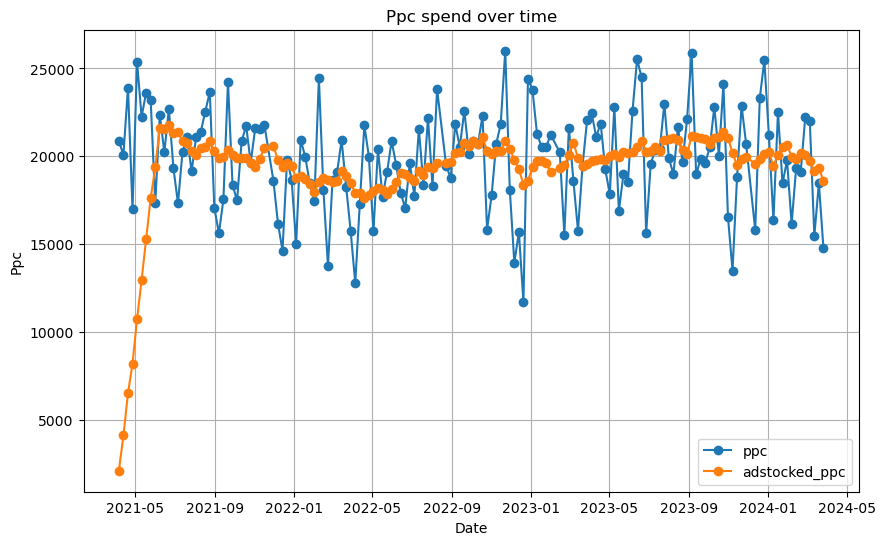

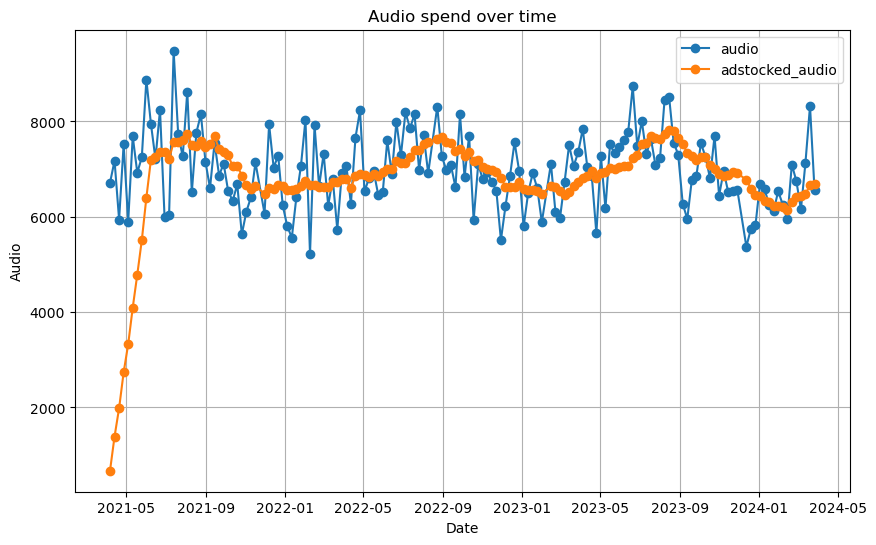

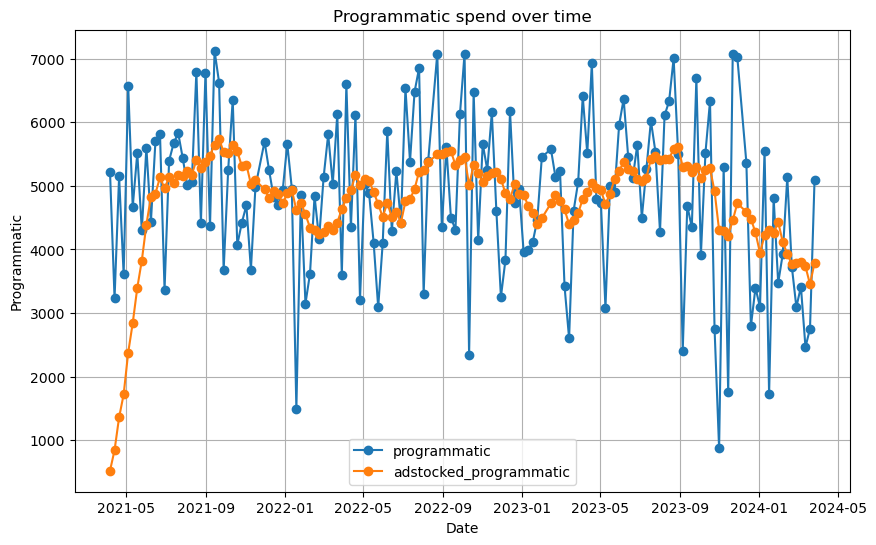

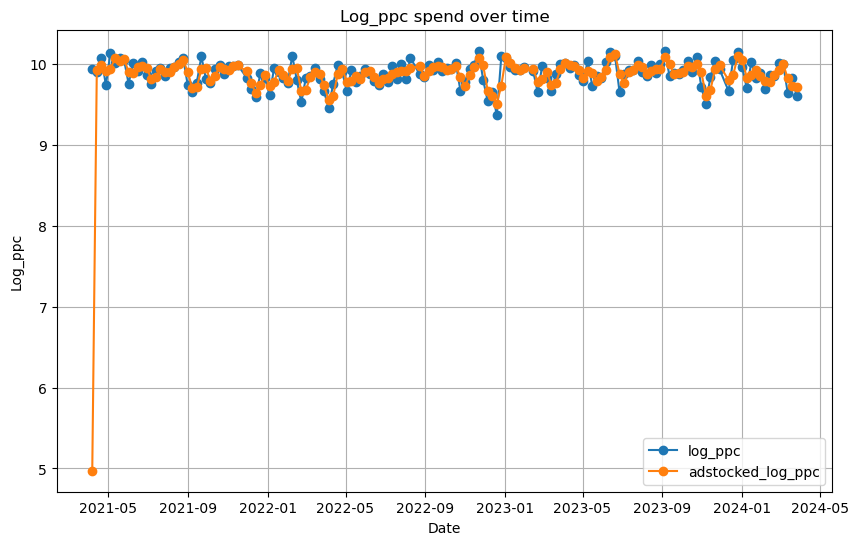

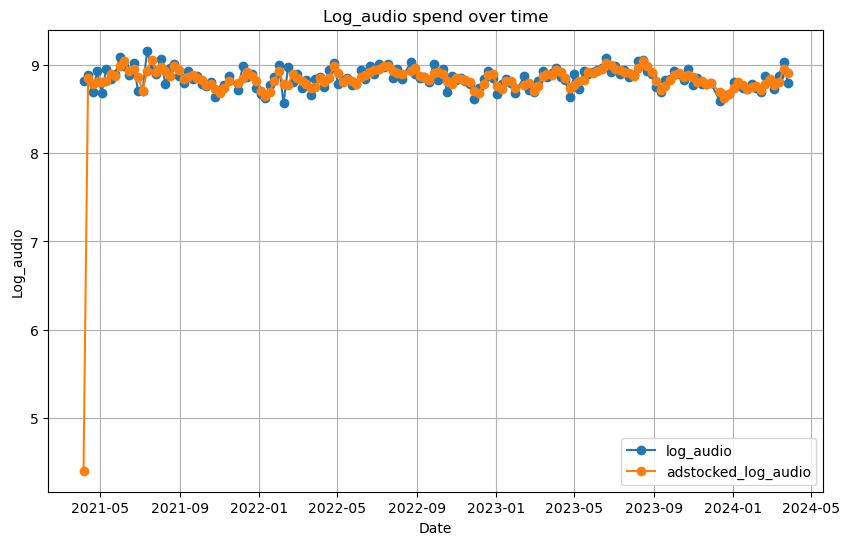

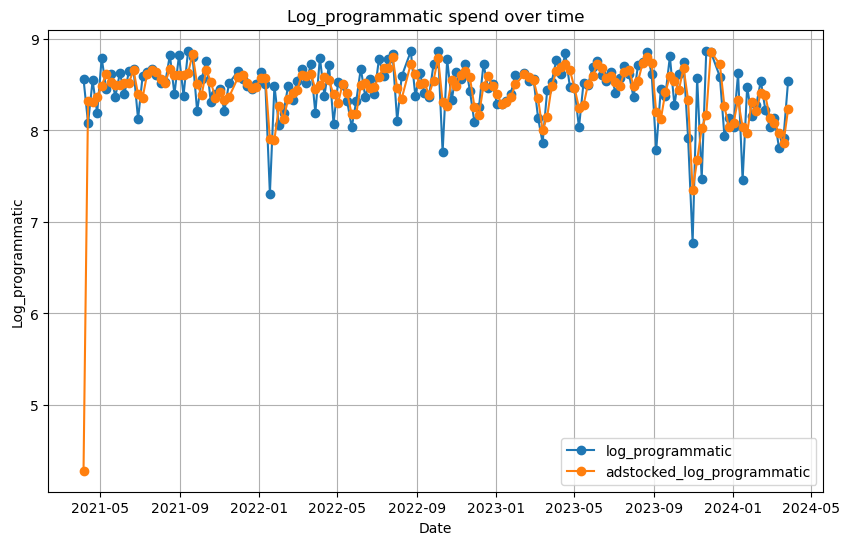

In [36]:
for key, column in grouped_columns.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each group
    for col in column:
        if ('log' not in key) & (col != 'ppc_programmatic_audio') & ('log' not in col):
            plt.plot(df.date, df[col], marker='o', label=col)
        elif ('log' in key) & (col != 'log_ppc_programmatic_audio'):
            plt.plot(df.date, df[col], marker='o', label=col)
    plt.title(f'{key.capitalize()} spend over time')
    plt.xlabel('Date')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
df.index = df['date']

In [38]:
df = df.asfreq('W', method='ffill')

In [39]:
df

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,...,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic
date,,,,,,,,,,,,,,,,,,,,,
2021-04-11,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,11.971076,...,8.811663,8.560872,7.308752e+11,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529
2021-04-18,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,11.898897,...,8.878494,8.080022,4.656133e+11,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920
2021-04-25,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,12.051863,...,8.689517,8.546151,7.310266e+11,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513
2021-05-02,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,11.927402,...,8.925253,8.191191,4.610180e+11,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255
2021-05-09,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,12.070624,...,8.682583,8.790183,9.825208e+11,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,2024-02-20,162632.197800,7200.257029,19099.027696,7094.368244,3730.828615,22.663469,163182.799990,8.881872,11.999246,...,8.867057,8.224386,5.055106e+11,26.948835,9.863397,8.778803,8.384082,20163.377478,6304.230432,3764.743171
2024-03-03,2024-02-27,151329.303068,6813.095961,22212.008767,6749.427632,3093.900164,22.445753,152925.069792,8.826602,11.927214,...,8.817213,8.037188,4.638324e+11,26.862789,9.932891,8.842135,8.130787,20054.017726,6404.386128,3794.451007
2024-03-10,2024-03-05,151239.716758,6766.224515,22023.434869,6154.942073,3414.808257,22.524531,152406.032036,8.819699,11.926621,...,8.725011,8.135877,4.628874e+11,26.860750,10.004125,8.771112,8.086532,19710.049087,6437.822861,3796.283509


In [40]:
df['date_adjusted'] = df.index

In [41]:
df['date_adjusted'].diff().value_counts()

date_adjusted
7 days    154
Name: count, dtype: int64

In [42]:
df.drop(columns=['date_adjusted'],inplace=True)

In [43]:
df.index.dtype

dtype('<M8[ns]')

# Training, validation, test split

In [44]:
# constructing training, validation and test sets
def data_train_validate_test(df, training_set_percent=0.7, validation_set_percent=0.15, seed=None):
  length = len(df.index)  #size of index of dataset
  training_set_end = int(training_set_percent * length)  #size of the training set
  validation_set_end = int(validation_set_percent * length) + training_set_end  #size of the validation set + training set
  training = df.iloc[:training_set_end] #select random rows up to the size of the training set to form the training dataset
  validation = df.iloc[training_set_end+1:validation_set_end] #select random rows up to the size of validation set to form the validation dataset
  test = df.iloc[validation_set_end+1:] #The remaining rows from the validation set onwards to the end will be the test dataset
  return training, validation, test

In [45]:
# generate training, validation and test sets
training, validation, test = data_train_validate_test(df)

In [46]:
# check the shapes of the training, validation and test sets
training.shape, validation.shape, test.shape

((108, 21), (22, 21), (23, 21))

In [47]:
#training = df

In [48]:
training

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,...,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic
date,,,,,,,,,,,,,,,,,,,,,
2021-04-11,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,11.971076,...,8.811663,8.560872,7.308752e+11,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529
2021-04-18,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,11.898897,...,8.878494,8.080022,4.656133e+11,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920
2021-04-25,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,12.051863,...,8.689517,8.546151,7.310266e+11,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513
2021-05-02,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,11.927402,...,8.925253,8.191191,4.610180e+11,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255
2021-05-09,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,12.070624,...,8.682583,8.790183,9.825208e+11,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,2023-03-28,165555.638214,7192.011570,22047.401203,7352.766134,5063.039093,22.842359,164282.508179,8.880726,12.017063,...,8.902832,8.529722,8.207662e+11,27.433504,9.938097,8.882647,8.483046,19551.268185,6723.200960,4567.832981
2023-04-09,2023-04-04,161774.966040,7467.409601,22448.292440,7840.025063,6407.953396,23.054725,172159.074126,8.918303,11.993962,...,8.966997,8.765295,1.127769e+12,27.751262,10.009960,8.934915,8.647509,19741.071039,6815.929778,4796.959367
2023-04-16,2023-04-11,157155.005362,6885.715274,21121.282419,7046.059483,5508.676684,23.065645,158823.464025,8.837204,11.964988,...,8.860224,8.614080,8.198112e+11,27.432340,9.988503,8.913611,8.689687,19800.101958,6860.520462,4901.558293


In [49]:
training.isna().values.any()

False

In [50]:
print(training.index.freq)

<Week: weekday=6>


In [51]:
training.index.dtype

dtype('<M8[ns]')

# Decomposing the signal, Dickey-Fuller tests and testing for stationarity

In [52]:
def decomposition(df,ts, period, extrapolate_trend):
    decomposition = seasonal_decompose(df[ts], period=period, extrapolate_trend=extrapolate_trend)
    New_df = df.copy()
    New_df.loc[:,'trend'] = decomposition.trend
    New_df.loc[:,'seasonal'] = decomposition.seasonal
    New_df.loc[:,'residuals'] = decomposition.resid
    return New_df

In [53]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2, figsize=(15,5), sharex=True)

  ax1.plot(df[ts],label="Original")
  ax1.legend(loc ='best')
  ax1.tick_params(axis ='x', rotation=45)

  ax2.plot(df[trend],label="Trend")
  ax2.legend(loc ='best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(df[seasonal],label="Seasonal")
  ax3.legend(loc ='best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(df[residual],label="Residuals")
  ax4.legend(loc = 'best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout()

  plt.show()

In [94]:
New_training = decomposition(training, 'log_revenue', period= 40, extrapolate_trend=1)
New_training

,date,revenue,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_revenue,...,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic,trend,seasonal,residuals
date,,,,,,,,,,,,,,,,,,,,,
2021-04-11,2021-04-06,158114.703977,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,11.971076,...,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529,12.013991,-0.019852,-0.023062
2021-04-18,2021-04-13,147104.213501,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,11.898897,...,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920,12.012784,-0.058168,-0.055720
2021-04-25,2021-04-20,171418.537449,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,12.051863,...,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513,12.011577,0.025533,0.014753
2021-05-02,2021-04-27,151357.842881,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,11.927402,...,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255,12.010371,0.019017,-0.101985
2021-05-09,2021-05-04,174664.757311,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,12.070624,...,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944,12.009164,0.093066,-0.031606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,2023-03-28,165555.638214,7192.011570,22047.401203,7352.766134,5063.039093,22.842359,164282.508179,8.880726,12.017063,...,27.433504,9.938097,8.882647,8.483046,19551.268185,6723.200960,4567.832981,11.991440,0.004453,0.021169
2023-04-09,2023-04-04,161774.966040,7467.409601,22448.292440,7840.025063,6407.953396,23.054725,172159.074126,8.918303,11.993962,...,27.751262,10.009960,8.934915,8.647509,19741.071039,6815.929778,4796.959367,11.992021,0.012582,-0.010642
2023-04-16,2023-04-11,157155.005362,6885.715274,21121.282419,7046.059483,5508.676684,23.065645,158823.464025,8.837204,11.964988,...,27.432340,9.988503,8.913611,8.689687,19800.101958,6860.520462,4901.558293,11.992601,-0.017633,-0.009980


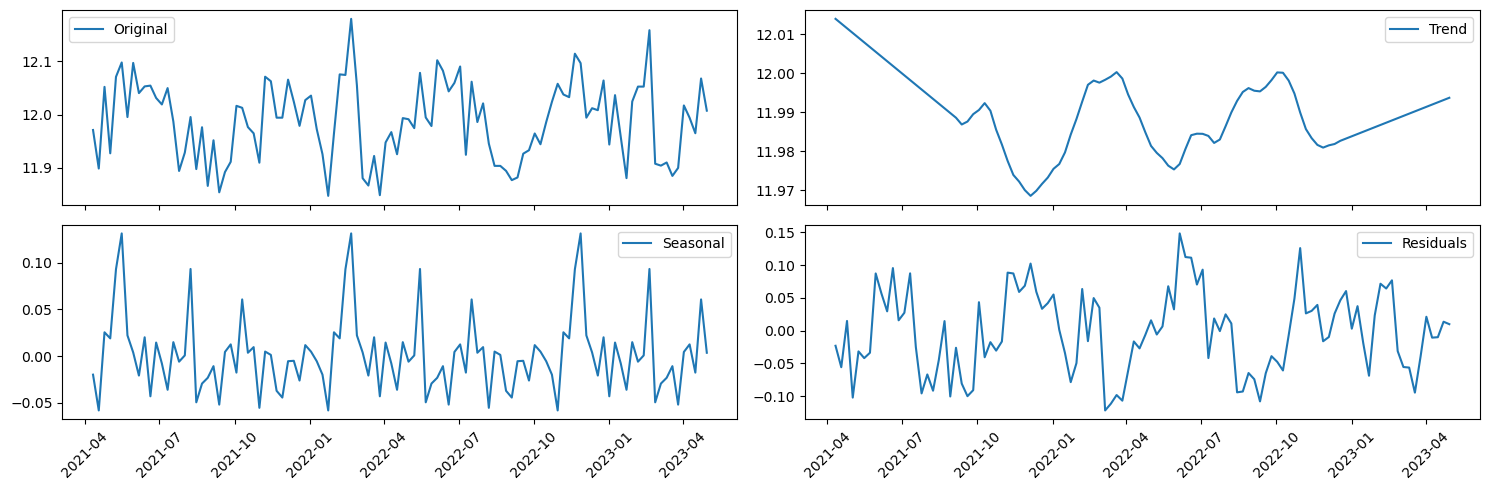

In [95]:
plot_decomposition(New_training,'log_revenue',trend='trend', seasonal='seasonal',residual='residuals')

In [96]:
def test_stationary(df, ts):
  #determine Rolling Statistics
  rolmean = df[ts].rolling(window=12, center = False).mean()
  rolstd = df[ts].rolling(window=12, center = False).std()

  orig = plt.plot(df[ts],color='blue',label='Original')
  mean = plt.plot(rolmean,color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling StD')

  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation =45)
  plt.show(block =False)
  plt.close

  #Dickey-Fuller test: Null Hypothesis (H_0): time series is not stationary
  #Alternate Hypothesis(H_1): time series is stationary 
  #p-value is the probability of an observed (or more extreme) result assuming that the null hypothesis is true 
  #if p-value is less than 0.05 then reject null hypothesis   


  print('Results:')
  dftest = adfuller(df[ts],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index =['Test Statistic','p-value','# Lags Used','Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key]= value

  print(dfoutput)

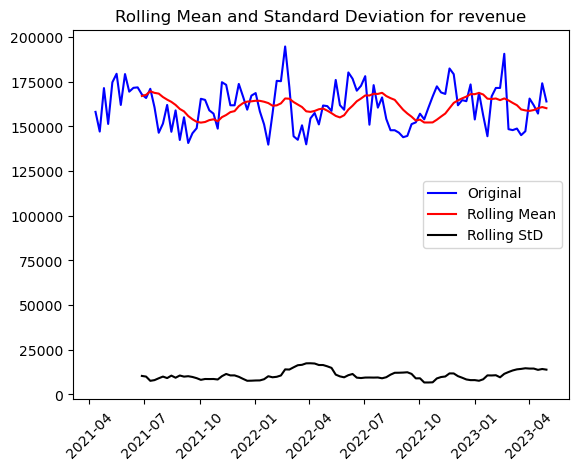

Results:
Test Statistic           -6.357286e+00
p-value                   2.524511e-08
# Lags Used               0.000000e+00
Number of Observations    1.070000e+02
Critical value(1%)       -3.492996e+00
Critical value(5%)       -2.888955e+00
Critical value(10%)      -2.581393e+00
dtype: float64


In [97]:
# test for stationarity on the full signal
test_stationary(New_training,'revenue')

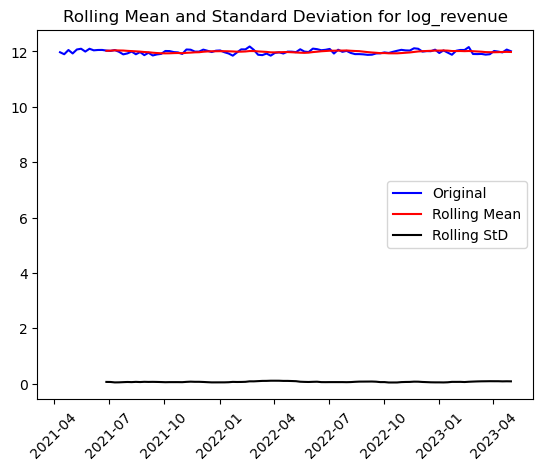

Results:
Test Statistic           -6.299688e+00
p-value                   3.436411e-08
# Lags Used               0.000000e+00
Number of Observations    1.070000e+02
Critical value(1%)       -3.492996e+00
Critical value(5%)       -2.888955e+00
Critical value(10%)      -2.581393e+00
dtype: float64


In [98]:
# test for stationarity on the log of the full signal
test_stationary(New_training,'log_revenue')

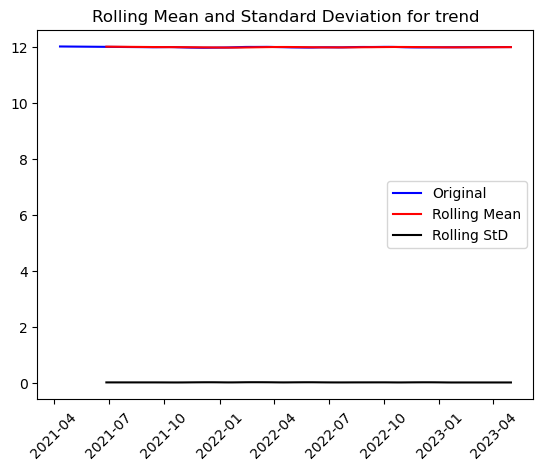

Results:
Test Statistic            -3.036681
p-value                    0.031608
# Lags Used               12.000000
Number of Observations    95.000000
Critical value(1%)        -3.501137
Critical value(5%)        -2.892480
Critical value(10%)       -2.583275
dtype: float64


In [99]:
test_stationary(New_training,'trend')

- therefore when carrying out a Dickey-Fuller test on the trend of the log revenue, we see that the p-value is greater than 0.05 hence we accept the null hypothesis that the time series for the log revenue trend is not stationary i.e. the mean and standard deviation are changing

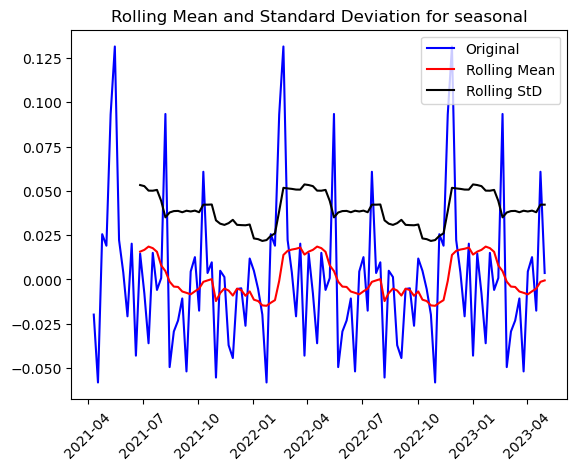

Results:
Test Statistic           -8.314193e+00
p-value                   3.718796e-13
# Lags Used               0.000000e+00
Number of Observations    1.070000e+02
Critical value(1%)       -3.492996e+00
Critical value(5%)       -2.888955e+00
Critical value(10%)      -2.581393e+00
dtype: float64


In [100]:
test_stationary(New_training,'seasonal')

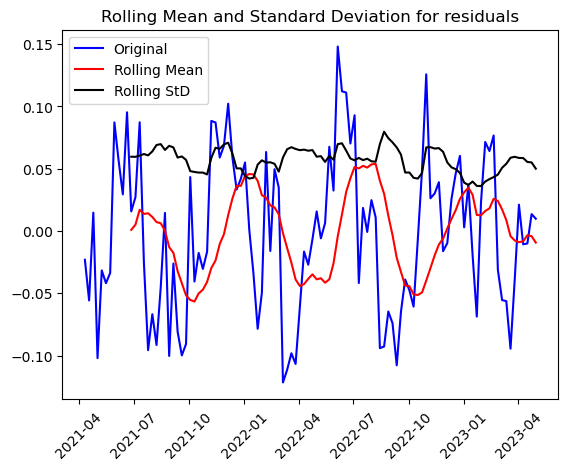

Results:
Test Statistic            -4.899284
p-value                    0.000035
# Lags Used               13.000000
Number of Observations    94.000000
Critical value(1%)        -3.501912
Critical value(5%)        -2.892815
Critical value(10%)       -2.583454
dtype: float64


In [101]:
# test for stationarity on the residuals
test_stationary(New_training, 'residuals')

# SARIMAX time series model

In [102]:
New_training.dtypes

date                          datetime64[ns]
revenue                              float64
sales                                float64
ppc                                  float64
audio                                float64
programmatic                         float64
price                                float64
sales x price                        float64
log_sales                            float64
log_revenue                          float64
log_ppc                              float64
log_audio                            float64
log_programmatic                     float64
ppc_programmatic_audio               float64
log_ppc_programmatic_audio           float64
adstocked_log_ppc                    float64
adstocked_log_audio                  float64
adstocked_log_programmatic           float64
adstocked_ppc                        float64
adstocked_audio                      float64
adstocked_programmatic               float64
trend                                float64
seasonal  

In [103]:
# set training y and X
#y_training = training['revenue']
y_training = New_training['residuals']
#X_training = training[['ppc','audio','programmatic']]
X_training = New_training[['sales','ppc','audio','programmatic','price','sales x price','log_sales','log_ppc','log_audio','log_programmatic','ppc_programmatic_audio','log_ppc_programmatic_audio','adstocked_log_ppc','adstocked_log_audio','adstocked_log_programmatic','adstocked_ppc','adstocked_audio','adstocked_programmatic']]
#X_training = New_training[['adstocked_audio']]

In [104]:
# check X training set
X_training

,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_ppc,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic
date,,,,,,,,,,,,,,,,,,
2021-04-11,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,9.944974,8.811663,8.560872,7.308752e+11,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529
2021-04-18,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,9.908105,8.878494,8.080022,4.656133e+11,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920
2021-04-25,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,10.082048,8.689517,8.546151,7.310266e+11,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513
2021-05-02,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,9.740259,8.925253,8.191191,4.610180e+11,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255
2021-05-09,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,10.140621,8.682583,8.790183,9.825208e+11,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,7192.011570,22047.401203,7352.766134,5063.039093,22.842359,164282.508179,8.880726,10.000950,8.902832,8.529722,8.207662e+11,27.433504,9.938097,8.882647,8.483046,19551.268185,6723.200960,4567.832981
2023-04-09,7467.409601,22448.292440,7840.025063,6407.953396,23.054725,172159.074126,8.918303,10.018970,8.966997,8.765295,1.127769e+12,27.751262,10.009960,8.934915,8.647509,19741.071039,6815.929778,4796.959367
2023-04-16,6885.715274,21121.282419,7046.059483,5508.676684,23.065645,158823.464025,8.837204,9.958036,8.860224,8.614080,8.198112e+11,27.432340,9.988503,8.913611,8.689687,19800.101958,6860.520462,4901.558293


In [105]:
y_training

date
2021-04-11   -0.023062
2021-04-18   -0.055720
2021-04-25    0.014753
2021-05-02   -0.101985
2021-05-09   -0.031606
                ...   
2023-04-02    0.021169
2023-04-09   -0.010642
2023-04-16   -0.009980
2023-04-23    0.013596
2023-04-30    0.009875
Freq: W-SUN, Name: residuals, Length: 108, dtype: float64

In [106]:
X_training

,sales,ppc,audio,programmatic,price,sales x price,log_sales,log_ppc,log_audio,log_programmatic,ppc_programmatic_audio,log_ppc_programmatic_audio,adstocked_log_ppc,adstocked_log_audio,adstocked_log_programmatic,adstocked_ppc,adstocked_audio,adstocked_programmatic
date,,,,,,,,,,,,,,,,,,
2021-04-11,6383.632381,20847.170468,6712.070406,5223.235285,22.923563,146335.596634,8.761493,9.944974,8.811663,8.560872,7.308752e+11,27.317509,4.972487,4.405831,4.280436,2084.717047,671.207041,522.323529
2021-04-18,6251.088147,20092.564981,7175.978317,3229.303912,22.913089,143231.740603,8.740511,9.908105,8.878494,8.080022,4.656133e+11,26.866621,9.926539,8.845079,8.320447,4093.973545,1388.804872,845.253920
2021-04-25,7442.020909,23909.892313,5940.313003,5146.905929,23.291401,173335.094873,8.914898,10.082048,8.689517,8.546151,7.310266e+11,27.317716,9.995076,8.784006,8.313086,6484.962776,1982.836173,1359.944513
2021-05-02,6568.636913,16987.943264,7519.485284,3609.017420,23.566207,154797.856058,8.790062,9.740259,8.925253,8.191191,4.610180e+11,26.856703,9.911153,8.807385,8.368671,8183.757103,2734.784701,1720.846255
2021-05-09,7585.449155,25352.214931,5899.261994,6569.436897,23.554130,178668.656776,8.933987,10.140621,8.682583,8.790183,9.825208e+11,27.613387,9.940440,8.803918,8.490687,10718.978596,3324.710900,2377.789944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,7192.011570,22047.401203,7352.766134,5063.039093,22.842359,164282.508179,8.880726,10.000950,8.902832,8.529722,8.207662e+11,27.433504,9.938097,8.882647,8.483046,19551.268185,6723.200960,4567.832981
2023-04-09,7467.409601,22448.292440,7840.025063,6407.953396,23.054725,172159.074126,8.918303,10.018970,8.966997,8.765295,1.127769e+12,27.751262,10.009960,8.934915,8.647509,19741.071039,6815.929778,4796.959367
2023-04-16,6885.715274,21121.282419,7046.059483,5508.676684,23.065645,158823.464025,8.837204,9.958036,8.860224,8.614080,8.198112e+11,27.432340,9.988503,8.913611,8.689687,19800.101958,6860.520462,4901.558293


In [107]:
start = X_training.index[0]
start

Timestamp('2021-04-11 00:00:00')

In [108]:
end = X_training.index[107]
end

Timestamp('2023-04-30 00:00:00')

In [109]:
def run_Sarimax(ts,x,p,d,q):
    #model = SARIMAX(ts,x, order=(p, d, q), seasonal_order=(1, 1, 1, 2))
    model = SARIMAX(ts,x, order=(p, d, q))
    sarimax_model = model.fit()
    print(sarimax_model.summary())
    print(sarimax_model.fittedvalues)

    len_results =len(sarimax_model.fittedvalues)
    rss = np.sum((y_training-sarimax_model.fittedvalues)**2)
    tss = np.sum((y_training-np.mean(y_training))**2)
    rmse=np.sqrt(rss/len(y_training))
    R_2 = (1-(rss/tss))
    print('rmse:',rmse)
    print('R_2:',R_2)
    print('rss:',rss)
    print('tss:',tss)
    plt.figure()
    plt.xticks(rotation =45)
    plt.plot(y_training, color='blue',label ='training log revenue residuals')
    plt.plot(sarimax_model.fittedvalues.iloc[2:], color='red',label ='SARIMAX predictions log revenue')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.show()
    return sarimax_model

C:\Users\vineetsivadasan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              residuals   No. Observations:                  108
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 216.506
Date:                Sun, 18 Aug 2024   AIC                           -391.013
Time:                        21:53:52   BIC                           -334.883
Sample:                    04-11-2021   HQIC                          -368.258
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sales                          0.0005   1.14e-08   3.99e+04      0.000       0.000       0.000
ppc                        -3.782e-06    1.8e-08   -209.761      0.000   -3.82e-06 

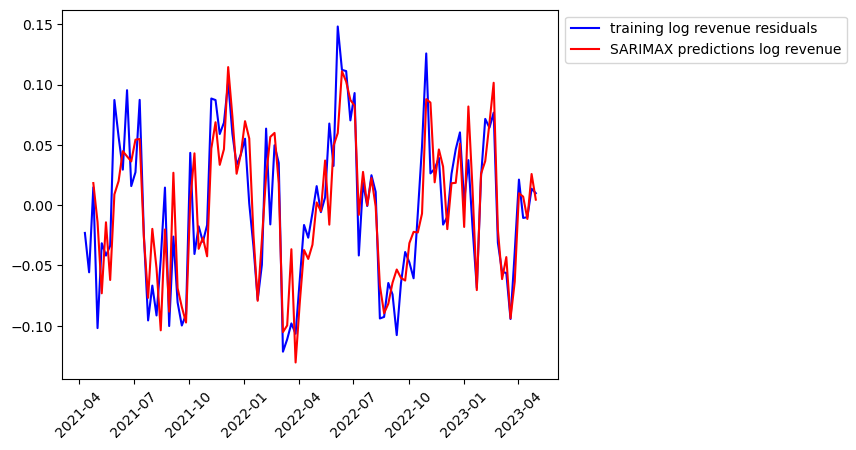

In [110]:
model_SA = run_Sarimax(ts=y_training,x=X_training,p=1,d=1,q=1)

In [96]:
pred = model_SA.predict(start=start, end=end, exog=X_training)

In [160]:
pred = model_SA.predict(start=start, end=end, exog=X_training).rename('SARIMAX Predictions')
pred_DF = pd.DataFrame(pred)
pred_DF['Date']=pred_DF.index

In [161]:
pred_DF

,SARIMAX Predictions,Date
date,,
2021-04-11,-0.048878,2021-04-11
2021-04-18,11.912587,2021-04-18
2021-04-25,11.912182,2021-04-25
2021-05-02,12.044259,2021-05-02
2021-05-09,11.931821,2021-05-09
...,...,...
2023-04-02,11.924160,2023-04-02
2023-04-09,11.967365,2023-04-09
2023-04-16,11.965223,2023-04-16


## Forecast

In [162]:
# set validation y and X
y_validation = validation['revenue']
#y_validation = validation['log_revenue']
X_validation = validation[['ppc','audio','programmatic']]
#X_validation = validation[['adstocked_ppc','adstocked_audio','adstocked_programmatic']]

In [163]:
X_validation

,ppc,audio,programmatic
date,,,
2023-05-14,22817.003376,6174.010045,3079.681108
2023-05-21,16884.599469,7518.686770,5004.340683
2023-05-28,18965.221962,7328.073312,4903.294281
2023-06-04,18534.523211,7453.706003,5953.937010
2023-06-11,22584.647716,7603.324892,6365.008403
2023-06-18,25530.067066,7777.369127,5455.789608
2023-06-25,24492.327778,8735.911839,5119.309975
2023-07-02,15624.899402,7482.280002,5646.371450
2023-07-09,19560.356615,8008.296143,4497.581711


In [164]:
y_validation

date
2023-05-14    173726.981027
2023-05-21    166911.397013
2023-05-28    172800.471356
2023-06-04    163264.140293
2023-06-11    166391.352854
2023-06-18    172261.201039
2023-06-25    170169.073347
2023-07-02    160020.904305
2023-07-09    166332.892971
2023-07-16    161185.018147
2023-07-23    154059.741768
2023-07-30    157358.021770
2023-08-06    156102.383380
2023-08-13    152514.894234
2023-08-20    162331.810073
2023-08-27    153067.270745
2023-09-03    146342.627908
2023-09-10    145484.841582
2023-09-17    153740.962003
2023-09-24    158254.527565
2023-10-01    158096.933208
2023-10-08    170900.288218
Freq: W-SUN, Name: revenue, dtype: float64

In [165]:
my_forecast = model_SA.forecast(22, exog=X_validation)

In [166]:
my_forecast

2023-05-07    12.010953
2023-05-14    12.065197
2023-05-21    12.047776
2023-05-28    12.043437
2023-06-04    12.131791
2023-06-11    12.102257
2023-06-18    12.033500
2023-06-25    12.075341
2023-07-02    12.088351
2023-07-09    11.973904
2023-07-16    12.084183
2023-07-23    12.028251
2023-07-30    12.047657
2023-08-06    11.953995
2023-08-13    11.921758
2023-08-20    11.954297
2023-08-27    11.928526
2023-09-03    11.948058
2023-09-10    11.935393
2023-09-17    11.952263
2023-09-24    11.961163
2023-10-01    11.987525
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [167]:
len(my_forecast)

22

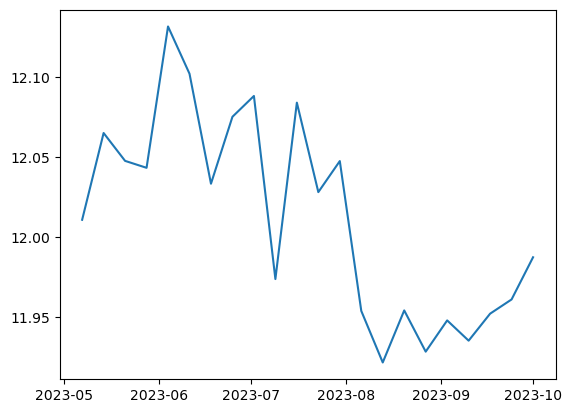

In [168]:
plt.plot(my_forecast)

## Validation

In [169]:
start_val = X_validation.index[0]
start_val

Timestamp('2023-05-14 00:00:00')

In [170]:
end_val = X_validation.index[20]
end_val

Timestamp('2023-10-01 00:00:00')

In [171]:
len(X_validation)

22

In [172]:
pred_val = model_SA.predict(start=start_val, end=end_val, exog=X_validation).rename('SARIMAX Predictions')
pred_val_DF = pd.DataFrame(pred_val)
pred_val_DF['Date']=pred_val_DF.index

In [173]:
pred_val_DF

,SARIMAX Predictions,Date
2023-05-14,12.065197,2023-05-14
2023-05-21,12.047776,2023-05-21
2023-05-28,12.043437,2023-05-28
2023-06-04,12.131791,2023-06-04
2023-06-11,12.102257,2023-06-11
2023-06-18,12.033500,2023-06-18
2023-06-25,12.075341,2023-06-25
2023-07-02,12.088351,2023-07-02
2023-07-09,11.973904,2023-07-09
2023-07-16,12.084183,2023-07-16


In [174]:
pd.DataFrame(y_validation)

,revenue
date,
2023-05-14,173726.981027
2023-05-21,166911.397013
2023-05-28,172800.471356
2023-06-04,163264.140293
2023-06-11,166391.352854
2023-06-18,172261.201039
2023-06-25,170169.073347
2023-07-02,160020.904305
2023-07-09,166332.892971


Text(0, 0.5, 'revenue')

<Figure size 640x480 with 0 Axes>

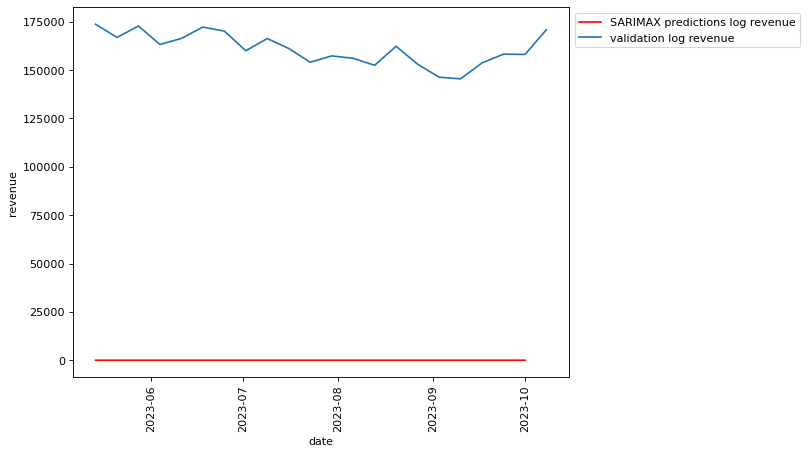

In [175]:
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plot_1, = plt.plot(pred_val_DF.index, pred_val_DF['SARIMAX Predictions'], color='red', label ='SARIMAX predictions log revenue')
plot_2, = plt.plot(y_validation.index, y_validation, label ='validation log revenue')
plt.legend(handles=[plot_1, plot_2], bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("revenue")

In [76]:
# calculate rmse error between SARIMAX predictions log revenue and vaildation log revenue
rss = np.sum((pred_val_DF['SARIMAX Predictions']-y_validation)**2)
rmse=np.sqrt(rss/len(y_validation))
print('rmse:',rmse)

rmse: 11142.47899702035


## Test

In [ ]:
# set validation y and X
y_test = test['log_revenue']
X_test = test[['adstocked_ppc','adstocked_audio','adstocked_programmatic']]

In [159]:
start_val = X_validation.index[0]
start_val

Timestamp('2023-05-14 00:00:00')

In [160]:
end_val = X_validation.index[20]
end_val

Timestamp('2023-10-01 00:00:00')

In [161]:
len(X_validation)

22

In [162]:
pred_val = model_SA.predict(start=start_val, end=end_val, exog=X_validation).rename('SARIMAX Predictions')
pred_val_DF = pd.DataFrame(pred_val)
pred_val_DF['Date']=pred_val_DF.index

In [163]:
pred_val_DF

,SARIMAX Predictions,Date
2023-05-14,12.101388,2023-05-14
2023-05-21,12.014364,2023-05-21
2023-05-28,11.999985,2023-05-28
2023-06-04,12.119705,2023-06-04
2023-06-11,12.104012,2023-06-11
2023-06-18,12.059736,2023-06-18
2023-06-25,12.079551,2023-06-25
2023-07-02,12.115808,2023-07-02
2023-07-09,11.952249,2023-07-09
2023-07-16,12.096197,2023-07-16


In [164]:
pd.DataFrame(y_validation)

,log_revenue
date,
2023-05-14,12.065240
2023-05-21,12.025218
2023-05-28,12.059893
2023-06-04,12.003125
2023-06-11,12.022098
2023-06-18,12.056767
2023-06-25,12.044548
2023-07-02,11.983060
2023-07-09,12.021746


Text(0, 0.5, 'revenue')

<Figure size 640x480 with 0 Axes>

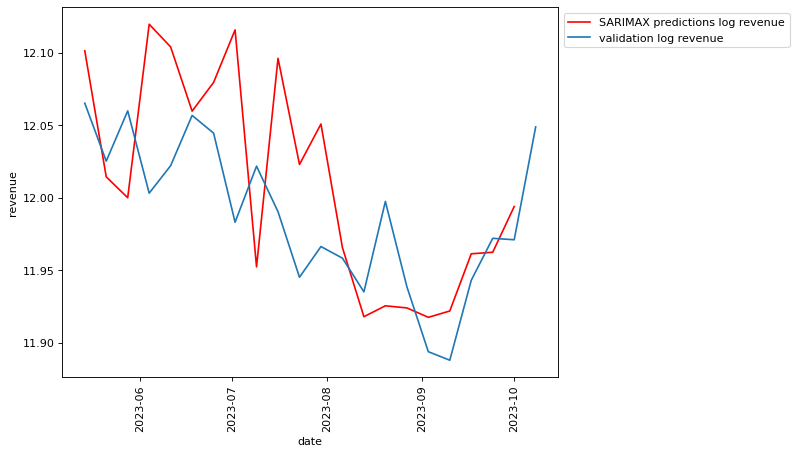

In [174]:
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plot_1, = plt.plot(pred_val_DF.index, pred_val_DF['SARIMAX Predictions'], color='red', label ='SARIMAX predictions log revenue')
plot_2, = plt.plot(y_validation.index, y_validation, label ='validation log revenue')
plt.legend(handles=[plot_1, plot_2], bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("revenue")